$$\large \color{green}{\textbf{Conducting the Backtest for the Value-At-Risk Models}}$$ 

$$\large \color{blue}{\textbf{Phuong Van Nguyen}}$$
$$\small \color{red}{\textbf{ phuong.nguyen@summer.barcelonagse.eu}}$$

This project is to introduce how to conduct test for the risk model validation.


# Loading lib

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from arch import arch_model
from timeit import default_timer as timer
import pandas as pd

In [76]:
from pickle import dump
from pickle import load
Purple= '\033[95m'
Cyan= '\033[96m'
Darkcyan= '\033[36m'
Blue = '\033[94m'
Green = '\033[92m'
Yellow = '\033[93m'
Red = '\033[91m'
Bold = "\033[1m"
Reset = "\033[0;0m"
Underline= '\033[4m'
End = '\033[0m'
from pprint import pprint

#  Load data

In [1]:
import numpy as np
price = np.loadtxt('index.csv',delimiter=',',skiprows=1)
y = np.diff(np.log(price), n=1, axis=0)  
y

array([ 0.00218138,  0.00153179,  0.00543592, ..., -0.00384422,
        0.00555516, -0.00560639])

In [2]:
len(y)

5676

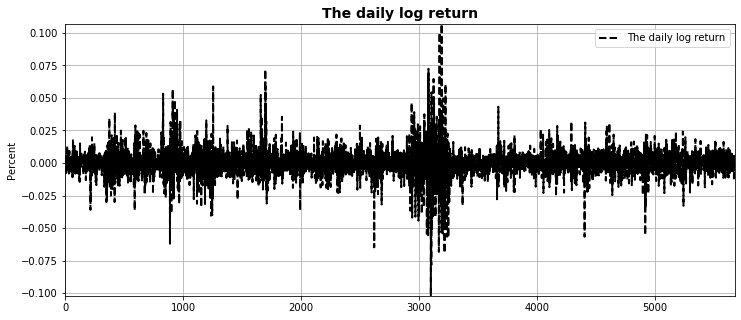

In [9]:
fig=plt.figure(figsize=(12,5))
plt.plot(y ,LineWidth=2,
         linestyle='--',label='The daily log return',color='k')
plt.title('The daily log return',fontsize=14,
          fontweight='bold',color='k')
plt.ylabel('Percent')
plt.autoscale(enable=True,axis='both',tight=True)
plt.legend()
plt.grid('on')
#plt.axis('off')

# Set backtesting

## Preliminary setting
### Initial parameters

In [10]:
T = len(y)                            # number of obs for y
WE = 1000                             # estimation window length
p = 0.01                              # probability
l1 = int(WE * p)                      # HS observation
value = 1                             # portfolio value
VaR = np.full([T,4], np.nan)          # matrix for forecasts
VaR.shape

(5676, 4)

### Bernoulli coverage test

In [ ]:
def bern_test(p,v):
    lv = len(v)
    sv = sum(v)
    al = np.log(p)*sv + np.log(1-p)*(lv-sv)
    bl = np.log(sv/lv)*sv + np.log(1-sv/lv)*(lv-sv)
    return (-2*(al-bl))

### Independence test

In [ ]:
def ind_test(V):
    J = np.full([T,4], 0)
    for i in range(1,len(V)-1):
        J[i,0] = (V[i-1] == 0) & (V[i] == 0)
        J[i,1] = (V[i-1] == 0) & (V[i] == 1)
        J[i,2] = (V[i-1] == 1) & (V[i] == 0)
        J[i,3] = (V[i-1] == 1) & (V[i] == 1)
    V_00 = sum(J[:,0])
    V_01 = sum(J[:,1])
    V_10 = sum(J[:,2])
    V_11 = sum(J[:,3])
    p_00=V_00/(V_00+V_01)
    p_01=V_01/(V_00+V_01)
    p_10=V_10/(V_10+V_11)
    p_11=V_11/(V_10+V_11)
    hat_p = (V_01+V_11)/(V_00+V_01+V_10+V_11)
    al = np.log(1-hat_p)*(V_00+V_10) + np.log(hat_p)*(V_01+V_11)
    bl = np.log(p_00)*V_00 + np.log(p_01)*V_01 + np.log(p_10)*V_10 + np.log(p_11)*V_11
    return (-2*(al-bl))

### EWMA setup

In [12]:
lmbda = 0.94
s11 = np.var(y[1:30])
for t in range(1,WE):
    s11=lmbda*s11+(1-lmbda)*y[t-1]**2
s11

0.00010627293306836045

## Conducting backtest 

In [26]:
win=[]
print('Starting:...')
start = timer()
for t in range(WE, T):
    win.append(t)
    # start of data window
    t1 = t - WE    
    # end of data window
    t2 = t - 1    
    # data for estimation in each window
    data_window = y[t1:t2+1] 
    #window=data_window
    # Estimating Model and forecasting VaR
    ## 1. EWMA
    s11 = lmbda * s11 + (1-lmbda) * y[t-1]**2
    VaR[t,0]=-stats.norm.ppf(p)*np.sqrt(s11)*value  
    ## 2. MA
    VaR[t,1]=-np.std(data_window,ddof=1)*stats.norm.ppf(p)*value   
    ## 3. HS
    ys = np.sort(data_window)
    VaR[t,2] = -ys[l1 - 1] * value 
         
print('The number of rolling windows: %d'%(len(win)))
print('Time: %fs'%(timer() - start))


Starting:...
The number of rolling windows: 4676
Time: 3.958144s


## Backtesting analysis
### Preliminary analysis
#### Plotting

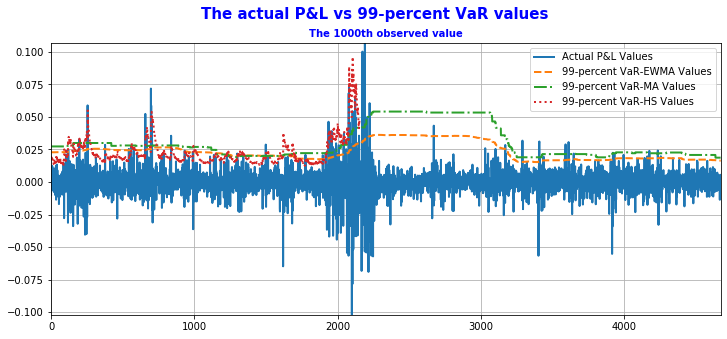

In [82]:
W1 = WE  
fig=plt.figure(figsize=(12,5))
plt.plot(y[W1:T],LineWidth=2,
         linestyle='-',label='Actual P&L Values')
plt.plot(VaR[W1:T,1],LineWidth=2,
         linestyle='--',label='%d-percent VaR-EWMA Values'%(100*(1-p)))
plt.plot(VaR[W1:T,2],LineWidth=2,
         linestyle='-.',label='%d-percent VaR-MA Values'%(100*(1-p)))
plt.plot(VaR[W1:T,3],LineWidth=2,
         linestyle=':',label='%d-percent VaR-HS Values'%(100*(1-p)))
plt.suptitle('The actual P&L vs %d-percent VaR values'%(100*(1-p)), 
             fontsize=15,fontweight='bold',
            color='b')
plt.title('The %dth observed value'%W1,fontsize=10,
          fontweight='bold',color='b')
plt.autoscale(enable=True,axis='both',tight=True)
plt.legend()
plt.grid('on')

#### Counting a number of exceedances

In [81]:
m = ["EWMA", "MA", "HS"]#, "GARCH"]
name=[]
exceedance=[]
frac_exceed=[]
std_var=[]
print('The number of allowing exceedances at the probability of %d percent: %d' %\
      (100*p,p*(T-WE)))
for i,nam in enumerate(m):
    # The number of exception or exceedance
    exception=sum(y[W1:T] < -VaR[W1:T,i])
    exceedance.append(exception)
    # The fraction of exceedance
    VR = sum(y[W1:T] < -VaR[W1:T,i])/(p*(T-WE))
    frac_exceed.append('{0:.2f}'.format(VR))
    # The standard diviation of the VaR
    s = np.std(VaR[W1:T, i], ddof=1)
    std_var.append(s)
    name.append(nam)
data_exceed=pd.DataFrame({'Method': name,
                          'Number of exceedance':exceedance,
                          'Fraction of exceedance': frac_exceed})
print(Bold+'The counting results:'+End)
print(data_exceed)

The number of allowing exceedances at the probability of 1 percent: 46
The counting results:
  Method  Number of exceedance Fraction of exceedance
0   EWMA                    97                   2.07
1     MA                    87                   1.86
2     HS                    58                   1.24


### Backtesting results and analysis


In [84]:
W1 = WE
ya = y[W1:T]
VaRa = VaR[W1:T,0:3]
m = ['EWMA', 'MA', 'HS']#, 'GARCH']
method=[]
unc_value=[]
unc_prob=[]
ind_value=[]
ind_prob=[]
for i,nam in enumerate(m):
    q = y[W1:T] < -VaR[W1:T,i]
    v = VaRa*0
    v[q,i] = 1
    ber = bern_test(p, v[:,i])
    ind = ind_test(v[:,i])
    method.append(nam)
    unc_value.append('{0:.2f}'.format(ber))
    unc_prob.append('{0:.2f}'.format(1 - stats.chi2.cdf(ber, 1)))
    ind_value.append('{0:.2f}'.format(ind))
    ind_prob.append('{0:.2f}'.format(1 - stats.chi2.cdf(ind, 1)))
testing_result=pd.DataFrame({'Method': method,
                          'Unconditional_coverage_value':unc_value,
                          'Unconditional_coverage_prob': unc_prob,
                            'Independent_value':ind_value,
                            'Independent_prob':ind_prob})
print(Bold+'The testing results:'+End)
testing_result
#print(testing_result)
    
    

The testing results:


,Method,Unconditional_coverage_value,Unconditional_coverage_prob,Independent_value,Independent_prob
0,EWMA,41.63,0.00,0.44,0.51
1,MA,27.90,0.00,17.44,0.00
2,HS,2.54,0.11,11.48,0.00


# Conclusion

One can see that in terms of the unconditional coverage test, the null hypothesis that the fraction of exceedance equals to the target probability is rejected in the case of EWMA and HS, but HS, at the significant level of 5 %. On the other hand, regarding the independent test, the null hypothesis that the exceedances are independent, is rejected at the significant level of 5% in the case of MA and HS, but EWMA.